### EKF slam and driving through poles

This jupyter notebook will use EKF slam to steer an imaginary rover through some poles. 

Again leaning heavily on the libraries from the PythonRobotics with some augmentations. 

In [1]:
from SLAM.ekfSlam import ekfSlam
from utils.rover import Rover
from Control import pose_control
import numpy as np
import matplotlib.pyplot as plt

The idea will be to identify a "lineup" pose that we should drive to in order to prepare for the rover to drive through the gates, then drive through the gates. Then stop. 

In [2]:
def targetPose(pole1,pole2):
    mid = ((pole1[1]+pole2[1])/2.0,(pole1[1]+pole2[1])/2.0)
    dy = pole2[1]-pole1[1]
    dx = pole2[0]-pole1[0]
    theta = np.arctan2(dx,dy)-np.pi/2
    return Rover(1*np.cos(theta)+mid[0],1*np.sin(theta)+mid[1],theta + np.pi)
    

In [3]:
pole = np.array([[10.0, 10.0],
                        [11.0, 11.0]])
# State Vector [x y yaw v]'
xEst = np.zeros((ekfSlam.STATE_SIZE, 1))
xTrue = np.zeros((ekfSlam.STATE_SIZE, 1))
PEst = np.eye(ekfSlam.STATE_SIZE)

xDR = np.zeros((ekfSlam.STATE_SIZE, 1))  # Dead reckoning

# history
hxEst = xEst
hxTrue = xTrue
hxDR = xTrue

## Setting up simulation.
T = 0.0
rov = Rover(0,0,0) # start it at the origin. 
v = 10
yawrate = 10
## Setting up control gains.

pose_control.dt = ekfSlam.DT = 0.01
poseGoal = [targetPose(pole[0],pole[1]),targetPose(pole[1],pole[0]), Rover(0,0,0)]
poseGoal[1].theta = poseGoal[0].theta
for i in range(len(poseGoal)):
    v = 10
    yawrate = 10
    while(v>0.01 or yawrate>0.01):
        T += ekfSlam.DT

        v,yawrate = pose_control.move_to_pose_step(rov,poseGoal[i])

        u = np.array([[v, yawrate]]).T
        xTrue, z, xDR, ud = ekfSlam.observation(xTrue, xDR, u, pole)

        xEst, PEst = ekfSlam.ekf_slam(xEst, PEst, ud, z)

        x_state = xEst[0:ekfSlam.STATE_SIZE]

        rov.x = xEst[0][0]
        rov.y = xEst[1][0]
        rov.theta = xEst[2][0]

        # store data history
        hxEst = np.hstack((hxEst, x_state))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))


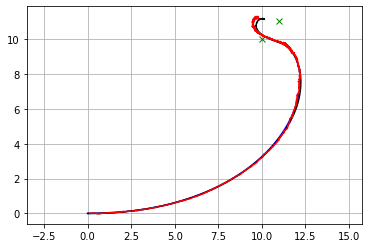

In [4]:
for i in range(ekfSlam.calc_n_LM(xEst)):
    plt.plot(xEst[ekfSlam.STATE_SIZE + i * 2],
            xEst[ekfSlam.STATE_SIZE + i * 2 + 1], "xg")

plt.plot(hxTrue[0, :],
        hxTrue[1, :], "-b")
plt.plot(hxDR[0, :],
        hxDR[1, :], "-k")
plt.plot(hxEst[0, :],
        hxEst[1, :], "-r")
plt.axis("equal")
plt.grid(True)
plt.pause(0.001)
plt.show()